In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
# https://en.wikipedia.org/wiki/Thornburg_v._Gingles#Opinion_of_the_Court
# https://en.wikipedia.org/wiki/Bartlett_v._Strickland
# Chapter 4 of https://sites.tufts.edu/vrdi/files/2019/06/The-Realists-Guide-to-Redistricting-2010-edition.pdf

state = 'NC'    # 2-letter state code
level = 'tract' # county, tract, block
district_type = 'SH'   # congressional district ('CD'), state senate district ('SS'), state house district ('SH')

# Which census codes to use for the minority group's voting age population (VAP):
#   'P00300004' : Black or African American alone
#   'P00300005' : American Indian and Alaska Native alone
#   'P00300006' : Asian alone
#   'P00400002' : Hispanic or Latino
# Full list at http://starr.tamu.edu/files/2013/01/Census-Codes.pdf

minority_vap_codes = [ 'P0030004' ]

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # Total Voting Age Population:
    G.nodes[node]['TVAP'] = G.nodes[node]['P0030001']
    
    # Minority Voting Age Population:
    G.nodes[node]['MVAP'] = sum( G.nodes[node][code] for code in minority_vap_codes )

In [3]:
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import congressional_districts_2020
from number_of_districts import state_senate_districts_2020
from number_of_districts import state_house_districts_2020

if district_type == 'CD':
    deviation = 0.01  # 1% population deviation (+/-0.5%)
    k = congressional_districts_2020[state]
elif district_type == 'SS':
    deviation = 0.10  # 10% population deviation (+/-5%)
    k = state_senate_districts_2020[state]
elif district_type == 'SH':
    deviation = 0.10  # 10% population deviation (+/-5%)
    k = state_house_districts_2020[state]

L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 82646 and U = 91344 and k = 120


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when county i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [5]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [6]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [7]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [8]:
def find_fischetti_separator(DG, component, b):
    
    neighbors_component = { i : False for i in DG.nodes }
    for i in nx.node_boundary(DG, component, None):
        neighbors_component[i] = True
    
    visited = { i : False for i in DG.nodes }
    child = [b]
    visited[b] = True
    
    while child:
        parent = child
        child = list()
        for i in parent:
            if not neighbors_component[i]:
                for j in DG.neighbors(i):
                    if not visited[j]:
                        child.append(j)
                        visited[j] = True
    
    C = [ i for i in DG.nodes if neighbors_component[i] and visited[i] ]
    return C

In [9]:
def cut_callback(m, where):
    if where == GRB.Callback.MIPSOL:
        
        DG = m._DG
        xval = m.cbGetSolution(m._x)
        selected = [ v for v in m._DG.nodes if xval[v] > 0.5 ]

        # pick a root ('b')
        largest_component =  max( nx.strongly_connected_components( DG.subgraph(selected) ), key=len )
        max_pop = max( DG.nodes[v]['TOTPOP'] for v in largest_component )
        max_pop_vertices = [ v for v in largest_component if DG.nodes[v]['TOTPOP'] == max_pop ]
        b = max_pop_vertices[0] 
              
        # add contiguty constraints
        for component in nx.strongly_connected_components( DG.subgraph(selected) ):
            if b not in component:
                max_pop = max( DG.nodes[v]['TOTPOP'] for v in component )
                max_pop_vertices = [ v for v in component if DG.nodes[v]['TOTPOP'] == max_pop ]
                a = max_pop_vertices[0]
                
                # we want a minimal a,b-separator C from the shore/neighborhood of 'component'
                C = find_fischetti_separator(DG, component, b)
                
                m.cbLazy( m._x[a] + m._x[b] <= 1 + gp.quicksum( m._x[c] for c in C ) )

In [10]:
# minority_voting_age_population >= 0.5 * total_voting_age_population
mvap = m.addVar()
tvap = m.addVar()

m.addConstr( mvap == gp.quicksum( G.nodes[i]['MVAP'] * x[i] for i in G.nodes ) )
m.addConstr( tvap == gp.quicksum( G.nodes[i]['TVAP'] * x[i] for i in G.nodes ) )

m.addConstr( mvap >= 0.5 * tvap )
m.update()

In [11]:
# Parameter settings
m.Params.TimeLimit = 600
m.Params.MIPGap = 0      # require full optimality
m.Params.Method = 3      # concurrent
m.Params.LazyConstraints = 1  # use lazy constraints

# Add contiguity constraints and solve
m._x = x
m._DG = DG
m._callback = cut_callback
m.optimize(m._callback)

# Retrieve the district
district = [ i for i in G.nodes if m._x[i].x > 0.5 ] 

Set parameter TimeLimit to value 600
Set parameter MIPGap to value 0
Set parameter Method to value 3
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 14851 rows, 17521 columns and 72793 nonzeros
Model fingerprint: 0x929d5167
Model has 1 quadratic constraint
Variable types: 5 continuous, 17516 integer (17516 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+04]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+04, 9e+04]
Presolve time: 0.06s
Presolved: 14851 rows, 17521 columns, 72793 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 3 continuous, 17518 integer (17516 binary)

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.00s

Barrier performed 0 iterations in 0.16 sec

In [12]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)
print("")
print("minority_voting_age_population =", round(mvap.x) )
print("total_voting_age_population =", round(tvap.x) )
print("minority's percentage =", round( 100 * mvap.x / tvap.x ),"%" )

The inverse PP score is 1.487748240141614
The PP score is 0.6721567352718315

minority_voting_age_population = 36786
total_voting_age_population = 68898
minority's percentage = 53 %


In [13]:
# Let's draw it on a map
import geopandas as gpd

In [14]:
# Read county shapefile from "<state>_county.shp"
filename = state + '_' + level + '.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

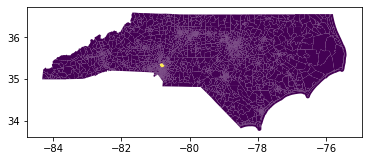

In [15]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()